In [2]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import matplotlib
from matplotlib import colors
import matplotlib.collections
from matplotlib import rc
import matplotlib.patches as mpatches

import warnings
warnings.filterwarnings('ignore')

rc("text", usetex=True)
plt.rcParams["font.family"] = "serif"
plt.rcParams["text.usetex"] = True

In [3]:
df = pd.read_csv('Clean_U.S._Urban_Heat_Island_Mapping_Campaign.csv')
df.rename(columns={'geoid': 'GEOID'}, inplace=True)

#make tree canopy something "negative" as well
df['Not Covered by Tree Canopy %'] = abs(df['Tree Canopy %'] - 100)

In [4]:
columns_to_check = [
    'Typical Afternoon Temperature in deg F',
    'Tree Canopy %',
    'Total Population',
    'Population Age < 5',
    'Population Age > 65',
    'Not Covered by Tree Canopy %'
]

# filter
df_filtered = df[columns_to_check + ['GEOID']]

# find rows (except in GEOID) contain zero values
rows_with_zero = df_filtered.loc[:, columns_to_check].eq(0).any(axis=1)
geoids_with_zero = df_filtered.loc[rows_with_zero, 'GEOID']

# save the GEOID values to a list or a new DataFrame
geoids_with_zero_list = geoids_with_zero.tolist()
geoids_with_zero_df = pd.DataFrame(geoids_with_zero, columns=['GEOID'])


In [5]:
def standardize_column(df, column_name):
    """
    Standardize a column in a DataFrame using z-score normalization.

    Parameters:
    - df (DataFrame): Input DataFrame.
    - column_name (str): Name of the column to be standardized.

    Returns:
    - DataFrame: DataFrame with the specified column standardized.
    """
    
    # Calculate mean and standard deviation of the column
    mean = df[column_name].mean()
    std = df[column_name].std()

    # Apply z-score normalization to the column
    df[column_name + '_standardized'] = (df[column_name] - mean) / std

    return df

standardize_column(df, "Typical Afternoon Temperature in deg F")
standardize_column(df, "Population Age < 5")
standardize_column(df, "Population Age > 65")
standardize_column(df, "Not Covered by Tree Canopy %")

,County,Region,GEOID,Typical Afternoon Temperature in deg F,Tree Canopy %,Total Population,Population Age < 5,Population Age > 65,Not Covered by Tree Canopy %,Typical Afternoon Temperature in deg F_standardized,Population Age < 5_standardized,Population Age > 65_standardized,Not Covered by Tree Canopy %_standardized
0,Travis County,Austin,48453000402,96.120699,17.319896,3661,289,436,82.680104,1.004117,0.192007,-0.278317,-0.476015
1,Travis County,Austin,48453000801,95.677093,18.807453,1794,95,322,81.192547,0.929715,-0.759727,-0.603081,-0.588482
2,Travis County,Austin,48453000802,95.754259,16.098322,3792,417,279,83.901678,0.942657,0.819955,-0.725580,-0.383658
3,Travis County,Austin,48453000803,95.932189,8.967548,2941,102,79,91.032452,0.972500,-0.725386,-1.295342,0.155466
4,Travis County,Austin,48453000804,95.985050,9.478316,2658,202,233,90.521684,0.981366,-0.234802,-0.856625,0.116849
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3861,Worcester County,Worcester,25027732901,85.348185,24.912122,7141,647,760,75.087878,-0.802658,1.948300,0.644698,-1.050026
3862,Worcester County,Worcester,25027732902,85.125313,25.946589,2827,0,10,74.053411,-0.840038,-1.225782,-1.491910,-1.128237
3863,Worcester County,Worcester,25027733000,86.111328,9.390215,3489,168,334,90.609785,-0.674663,-0.401600,-0.568895,0.123510
3864,Worcester County,Worcester,25027733101,84.615175,25.928962,2208,88,335,74.071038,-0.925599,-0.794068,-0.566047,-1.126905


In [6]:
#define weights
w1 = 1
w2 = 1
w3 = 1
w4 = 1

df['Score'] = ((w1 * df['Typical Afternoon Temperature in deg F_standardized'])
+ (w2*df['Population Age < 5_standardized']) 
+ (w3 * df['Population Age > 65_standardized']) 
+ (w4 * df['Not Covered by Tree Canopy %_standardized']))

#make all values positive

minimum = df['Score'].min()
df['Score'] = df['Score'] + abs(minimum)


In [7]:
columns_to_drop = ['County', 'Typical Afternoon Temperature in deg F', 
                   'Tree Canopy %', 'Total Population', 
                   'Population Age < 5', 'Not Covered by Tree Canopy %', 
                   'Population Age > 65', 'Typical Afternoon Temperature in deg F_standardized', 
                   'Population Age < 5_standardized',  
                   'Population Age > 65_standardized', 'Not Covered by Tree Canopy %_standardized' ]
df = df.drop(columns=columns_to_drop)

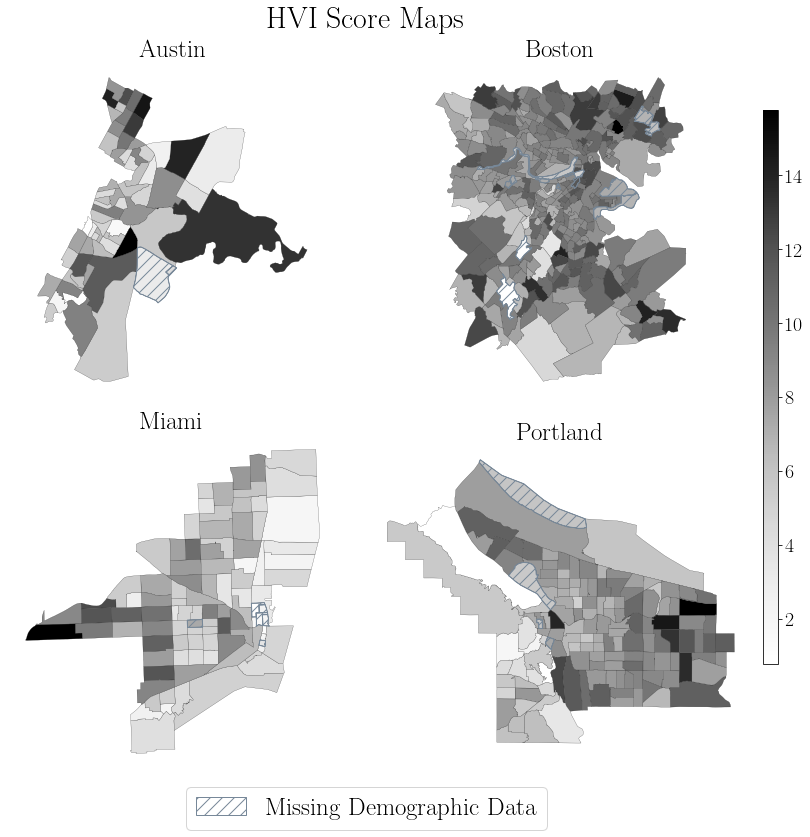

In [8]:
# Define a function to create the plot for a specific region
def plot_region(df, region, geojson_file, ax, geoids_with_zero):
    df_region = df[df['Region'] == region]
    gdf_region = gpd.read_file(geojson_file)
    gdf_region = gdf_region[['GEOID', 'geometry']]
    
    gdf_region['GEOID'] = gdf_region['GEOID'].astype(int)
    df_region['GEOID'] = df_region['GEOID'].astype(int)
    
    gdf_region = gdf_region[gdf_region['GEOID'].isin(df_region['GEOID'])]
    gdf_region = pd.merge(gdf_region, df_region, on='GEOID', how='outer')
    
    # Plot the main data
    gdf_region.plot(column='Score', cmap='Greys', linewidth=0.2, ax=ax, edgecolor='0.1', legend=False)
    
    # Plot hatching for regions with zero values
    gdf_hatched = gdf_region[gdf_region['GEOID'].isin(geoids_with_zero)]
    if not gdf_hatched.empty:
        gdf_hatched.boundary.plot(ax=ax, color='lightslategrey', linewidth=0.5)
        gdf_hatched.plot(ax=ax, facecolor="none", edgecolor='lightslategrey', hatch='//')
    
    ax.set_title(f'{region}', size=25)
    ax.set_xticks([])
    ax.set_yticks([])
    
    return gdf_region

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(11, 11))

# Plot each region and collect all the GeoDataFrames for shared colorbar
gdf_all = []
gdf_all.append(plot_region(df, 'Boston', 'Shapefile/Massachusetts.json', axs[0, 1], geoids_with_zero_list))
gdf_all.append(plot_region(df, 'Austin', 'Shapefile/Texas.json', axs[0, 0], geoids_with_zero_list))
gdf_all.append(plot_region(df, 'Miami', 'Shapefile/Florida.json', axs[1, 0], geoids_with_zero_list))
gdf_all.append(plot_region(df, 'Portland', 'Shapefile/Oregon.json', axs[1, 1], geoids_with_zero_list))

# Combine all data for a shared colorbar
combined_gdf = pd.concat(gdf_all)

# Create a single colorbar axis
cbar_ax = fig.add_axes([1, 0.15, 0.02, 0.7])  # Adjust these values as needed

# Create a ScalarMappable for the colorbar
sm = plt.cm.ScalarMappable(cmap='Greys', norm=plt.Normalize(vmin=combined_gdf['Score'].min(), vmax=combined_gdf['Score'].max()))
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='vertical')
cbar.ax.tick_params(labelsize=20)  # Increase size of colorbar ticks

# Set the border color of each subplot to white
for ax in axs.flatten():
    for spine in ax.spines.values():
        spine.set_edgecolor('white')

# Add a legend for hatching
hatch_patch = mpatches.Patch(facecolor='none', edgecolor='lightslategrey', hatch='//', label='Missing Demographic Data')
fig.legend(handles=[hatch_patch], loc='upper center', bbox_to_anchor=(0.5, 0.01), ncol=1, fontsize=25)

plt.suptitle('HVI Score Maps', size = 30)
plt.subplots_adjust(right=0.9)  # Adjust right margin to make room for the colorbar
plt.tight_layout() 
#plt.savefig('score_map.png', dpi=300, bbox_inches='tight')
plt.show()
